In [51]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [52]:
y, sr = librosa.load("./record-test.mp3")

#### Let's reproduce it in order to compare with the audio we'll create in a few cells.

In [53]:
ipd.Audio(y, rate=sr)

#### Plot the sound wave
Comparing the following sound wave with the final one, we'll notice that those intervals of time when silences were detected (estimated) will mostly disappear.

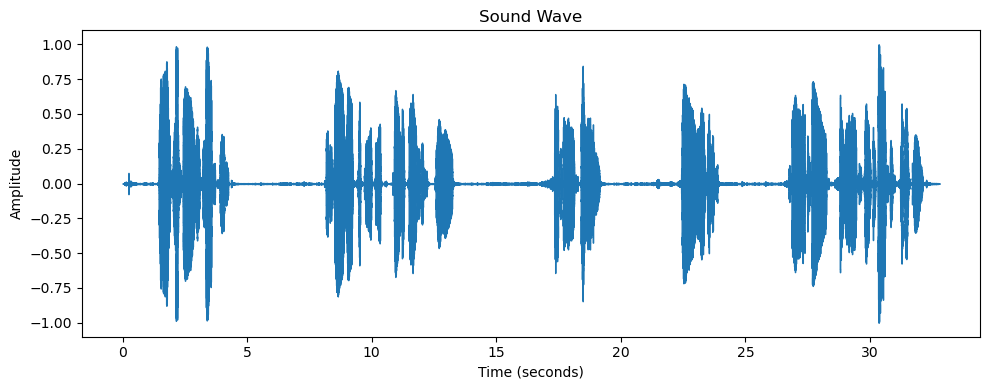

In [54]:
duration = librosa.get_duration(y=y, sr=sr)
plt.figure(figsize = (10, 4))
librosa.display.waveshow(y=y, sr=sr)
plt.title("Sound Wave")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

### Working with decibels
The sound samples in 'y' value are amplitudes. In order to find a basic estimation, we'll need to convert these values to scale them. Decibels are a good choice since its based on exponential.

In [55]:
dBs = librosa.amplitude_to_db(librosa.feature.rms(y=y), ref=np.max)

### Threshold
Due to time restriction, for now we got an estimation from an external tool that generates the best regression function that matches mostly with the value 'x' as one axis and the supervised (hard-coded threshold values) as the 'y' axis.

#### Estimation Function
The regression function that mostly fit the values was a 'Logistic Regression'

$$
th(x) = \frac{35.0908213894409}{1 + 10.061321079933 \cdot e^{-0.1239918917878 \cdot x}}
$$

In [56]:
def th(x):
    return 35.0908213894409 / (1 + 10.061321079933 * np.e**(-0.1239918917878 * x))

In [57]:
mean_dBs = np.mean(dBs)
std = np.std(dBs)
x_value = np.abs(mean_dBs - std)
y_value = th(x_value)

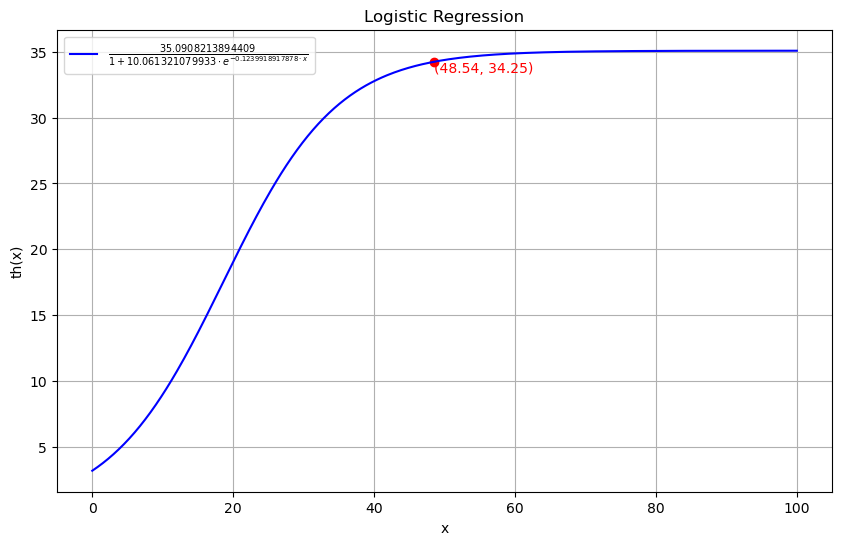

In [58]:
x_points = np.linspace(0, 100, 400)
y_points = th(x)
plt.figure(figsize=(10, 6))
plt.plot(x_points, y_points, label=r'$\frac{35.0908213894409}{1 + 10.061321079933 \cdot e^{-0.1239918917878 \cdot x}}$', color='blue')
plt.scatter(x_value, y_value, color='red') 
plt.text(x_value, y_value, f'({x_value:.2f}, {y_value:.2f})', verticalalignment='top', horizontalalignment='left', color='red')
plt.xlabel('x')
plt.ylabel('th(x)')
plt.title('Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

### Splitting based on the threshold
We can filter those samples stored in 'y' based on the threshold we found.

In [59]:
# now let's use the threshold to detect the sound intervals
sound_intervals = librosa.effects.split(y, top_db=y_value)
sound_intervals_sec = [[element / sr for element in subarray] for subarray in sound_intervals]

# print them
print("Sound intervals (in seconds): ")
for start, end in sound_intervals_sec:
    print(f"{start:.2f}s - {end:.2f}s")

Sound intervals (in seconds): 
1.39s - 3.76s
3.85s - 4.27s
8.10s - 9.29s
9.38s - 9.61s
9.66s - 10.05s
10.10s - 10.43s
10.80s - 11.35s
11.45s - 12.26s
12.52s - 13.31s
17.14s - 18.30s
18.34s - 19.20s
21.43s - 21.55s
22.31s - 23.94s
26.59s - 28.33s
28.35s - 28.37s
28.61s - 31.05s
31.16s - 31.63s
31.65s - 32.16s


### Plotting intervals of wave where sound was detected

- Green vertical line represents the sound interval's start
- Red vertical line represents sound interval's end

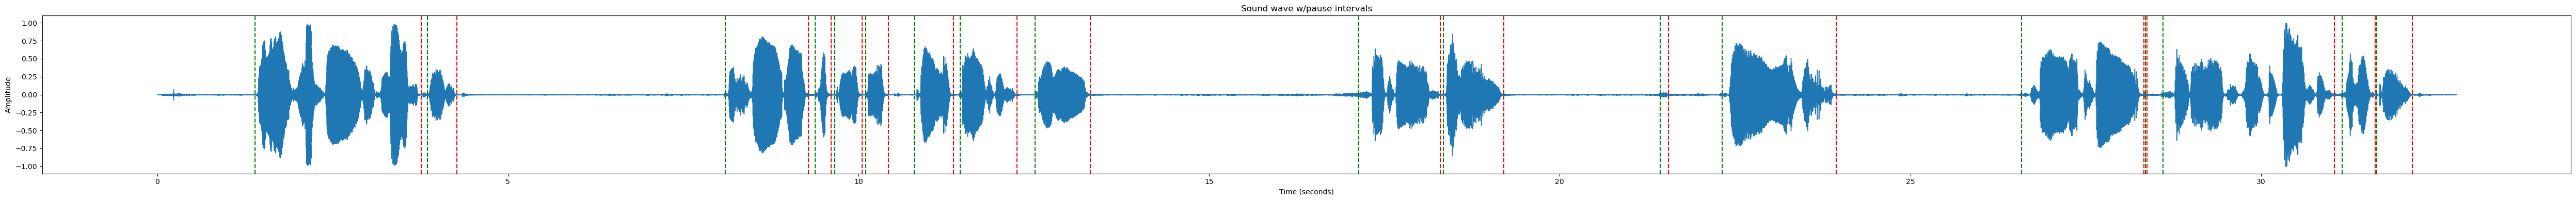

In [60]:
# sound wave
plt.figure(figsize=(50, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Sound wave w/pause intervals')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# add start(green) and end(red) intervals where there sound IS DETECTED
for start, end in sound_intervals_sec:
  plt.axvline(start, color='g', linestyle='--')
  plt.axvline(end, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### Deleting pauses 
Once sound intervals were found, they can be inverted. This'll generate the silent intervals, and these can be deleted from de original audio. 

In [61]:
duration = librosa.get_duration(y=y,sr=sr)
silence_intervals = []
start = 0

for sound_interval in sound_intervals_sec:
  end = sound_interval[0]
  if end > start:
    silence_intervals.append([start, end])
  start = sound_interval[1]
if start < duration:
  silence_intervals.append([start, duration])

segments_to_detele = [[int(start * sr), int(end * sr)] for start, end in silence_intervals]

### Audio without pauses and its sound wave

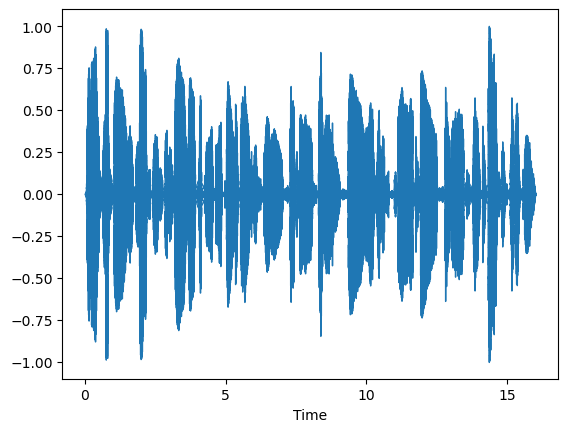

In [62]:
mask = np.ones(len(y), dtype=bool)
for start, end in segments_to_detele:
    mask[start:end] = False

non_segmented_y = y[mask]

# show new audio without pauses and its sound wave
librosa.display.waveshow(non_segmented_y, sr=sr)

ipd.Audio(non_segmented_y, rate=sr)

### Conclusions
From a normal recording made by me, we removed all significant pauses. 

The pause threshold was estimated using logistic regression.

You can repeat the process with a different audio file if you want to.

> Note: There were only a few samples, so the regression is strong, but not as strong as we wished. So, if anomalies appear, keep it in mind.